In [ ]:
!pip install sacremoses

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 56.6 MB/s eta 0:00:00


In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("feature-extraction", model="allegro/herbert-base-cased")

Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.sso.sso_relationship.bias', 'cls.sso.sso_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("allegro/herbert-base-cased")
model = AutoModel.from_pretrained("allegro/herbert-base-cased")

Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.sso.sso_relationship.bias', 'cls.sso.sso_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
res = model(**tokenizer("Today is a sunny day and I will get some ice cream.", return_tensors="pt"))
tokenizer.decode(res.last_hidden_state[0][0])

torch.Size([1, 23, 768])


In [1]:
from tabulate import tabulate
from tqdm import tqdm, trange
import os
import random
import math
import json
from collections import defaultdict
from itertools import combinations
import numpy as np
from tqdm import tqdm
import torch
from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM
from datasets import load_dataset
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.utils.extmath import randomized_svd
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
import os
import random
import math
import json
from collections import defaultdict
from itertools import combinations
import numpy as np
from tqdm import tqdm
import torch
from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM
from datasets import load_dataset
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.utils.extmath import randomized_svd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODELS = {
    "polish-gpt2": "sdadas/polish-gpt2-medium",
    "herbert": "allegro/herbert-base-cased"
}
DATASET = "clarin-knext/wsd_polish_datasets"
OUTDIR = "plots_wsd"
os.makedirs(OUTDIR, exist_ok=True)
RESULTS_PATH = os.path.join(OUTDIR, "results_summary.json")
MAX_SENTENCES = 20000
MIN_OCCURRENCES = 5
SAMPLE_WORDS = 1000
RANDOM_POOL_SIZE = 1000
SAMPLE_SENTENCES = 1000
BATCH_SIZE = 16
DATASET_URL = "https://huggingface.co/datasets/clarin-knext/wsd_polish_datasets/resolve/main/data/skladnica_sentences.jsonl"

def load_wsd_sentences(max_sentences=None, fraction=1.0):
    print("Loading dataset:", DATASET_URL)
    ds = load_dataset("json", data_files=DATASET_URL, split="train")

    sentences = []
    for ex in tqdm(ds, desc="iterating documents"):
        for sent in ex.get("sentences", []):
            sentences.append(sent)
            if max_sentences and len(sentences) >= max_sentences:
                break
        if max_sentences and len(sentences) >= max_sentences:
            break

    if 0 < fraction < 1.0:
        import random
        random.seed(42)
        k = int(len(sentences) * fraction)
        sentences = random.sample(sentences, k)
        print(f"Subsampled {k} / {len(ds)} sentences ({fraction*100:.0f}%)")

    print(f"Loaded {len(sentences)} sentences total")
    return sentences

def map_occurrences_from_dataset(sentences, tokenizer):
    """
    Use dataset token char spans (position) to directly align with tokenizer offset_mapping.
    Returns:
      occurrences: dict key -> list of occurrences
        here key = lemma (you can also use orth if desired)
        occurrence item: dict(sentence_idx, token_idx_in_sentence, char_span, model_token_indices)
      tokenized_cache: dict sentence_idx -> tokenizer encoding (offsets, input_ids)
    """
    occurrences = defaultdict(list)
    tokenized_cache = {}

    for sidx, ex in enumerate(tqdm(sentences, desc="Tokenizing sentences (fast tokenizer)")):
        text = ex["text"]
        # use fast tokenizer to get offsets; add_special_tokens True so we must map accordingly
        enc = tokenizer(text, return_offsets_mapping=True, add_special_tokens=True)
        offsets = enc["offset_mapping"]  # list of (start,end) per model token, includes special tokens
        input_ids = enc["input_ids"]
        tokenized_cache[sidx] = enc

        # Build for each dataset token (dataset provides tokens with 'position' e.g. [start,end])
        for tok in ex.get("tokens", []):
            idx_in_sent = tok["index"]
            char_span = tok["position"]  # [start, end)
            lemma = tok.get("lemma", tok.get("orth"))
            # find model token indices whose offsets overlap this char span (ignore special tokens where offsets == (0,0) for some tokenizers)
            model_token_indices = []
            for mt_idx, (tstart, tend) in enumerate(offsets):
                # offset mapping uses 0-based char indices relative to original text
                # some special tokens have (0,0) - skip those if they don't overlap
                if tstart == tstart and (tstart, tend) == (0, 0) and not (char_span[0]==0 and char_span[1]==0):
                    # skip special token with (0,0) unless actual char span is (0,0)
                    continue
                # overlap test
                if not (tend <= char_span[0] or tstart >= char_span[1]):
                    model_token_indices.append(mt_idx)
            if len(model_token_indices) == 0:
                # fallback: sometimes tokenizer normalization changes characters; try matching by substring
                # find token text pieces that equal tok['orth'] or startswith
                # but we won't attempt heavy heuristics here; skip
                continue
            occurrences[lemma].append({
                "sentence_idx": sidx,
                "token_index_in_sentence": idx_in_sent,
                "char_span": char_span,
                "model_token_indices": model_token_indices
            })
    return occurrences, tokenized_cache


def plot_words_stats_per_layer(model_name, occurrences, all_sentence_layer_states, num_words=10, outdir=OUTDIR):
    """
    Plot raw and adjusted SelfSim, MEV, and IntraSim per layer for num_words random words.
    """
    candidate_words = [w for w, occs in occurrences.items() if len(occs) >= MIN_OCCURRENCES]
    sampled_words = random.sample(candidate_words, min(num_words, len(candidate_words)))
    per_word_results = {}
    for word in sampled_words:
        occs = occurrences[word]
        per_layer_self = []
        per_layer_adj_self = []
        per_layer_intra = []
        per_layer_adj_intra = []
        per_layer_mev = []
        per_layer_adj_mev = []

        n_layers = len(all_sentence_layer_states[next(iter(all_sentence_layer_states))])

        # Flatten all occurrences for anisotropy baseline
        flat_occ = [(w2, o) for w2, occs2 in occurrences.items() for o in occs2]
        random_pool = random.sample(flat_occ, min(RANDOM_POOL_SIZE, len(flat_occ)))
        baseline_pool = {L: [] for L in range(n_layers)}
        for w_, occ in random_pool:
            sidx = occ["sentence_idx"]
            model_token_idxs = occ["model_token_indices"]
            per_layer_arrays = all_sentence_layer_states[sidx]
            for L in range(n_layers):
                baseline_pool[L].append(per_layer_arrays[L][model_token_idxs].mean(axis=0))
        for L in baseline_pool:
            baseline_pool[L] = np.stack(baseline_pool[L], axis=0)
        anisotropy = {L: mean_pairwise_cosine_no_diag(baseline_pool[L]) for L in range(n_layers)}

        for L in range(n_layers):
            mats = []
            for occ in occs:
                sidx = occ["sentence_idx"]
                model_token_idxs = occ["model_token_indices"]
                mats.append(all_sentence_layer_states[sidx][L][model_token_idxs].mean(axis=0))
            if len(mats) < 2:
                per_layer_self.append(np.nan)
                per_layer_adj_self.append(np.nan)
                per_layer_mev.append(np.nan)
                per_layer_adj_mev.append(np.nan)
                continue
            mats = np.stack(mats, axis=0)
            selfsim = mean_pairwise_cosine_no_diag(mats)
            per_layer_self.append(selfsim)
            per_layer_adj_self.append(selfsim - anisotropy[L])

            try:
                U, S, Vt = np.linalg.svd(mats.astype(np.float32), full_matrices=False)
                sigma_sq = (S**2).sum()
                mev = (S[0]**2)/sigma_sq if sigma_sq>0 else 0.0
            except:
                mev = np.nan
            per_layer_mev.append(mev)
            # Adjusted MEV
            try:
                sigma_sq_baseline = (np.linalg.svd(baseline_pool[L].astype(np.float32), full_matrices=False)[1]**2).sum()
                mev_baseline = (np.linalg.svd(baseline_pool[L].astype(np.float32), full_matrices=False)[1][0]**2) / sigma_sq_baseline
            except:
                mev_baseline = 0.0
            per_layer_adj_mev.append(mev - mev_baseline)

        per_word_results[word] = {
            "self": per_layer_self,
            "adj_self": per_layer_adj_self,
            "mev": per_layer_mev,
            "adj_mev": per_layer_adj_mev
        }

    # save per words results
    with open(os.path.join(outdir, f"{model_name}_per_word_results.json"), "w", encoding="utf-8") as f:
        json.dump(per_word_results, f, indent=2, ensure_ascii=False)

    # Plot per word
    layers = list(range(n_layers))
    for word, vals in per_word_results.items():
        plt.figure(figsize=(12,5))
        plt.plot(layers, vals["self"], marker='o', label="SelfSim (raw)")
        plt.plot(layers, vals["adj_self"], marker='o', label="SelfSim (adjusted)")
        plt.plot(layers, vals["mev"], marker='x', label="MEV (raw)")
        plt.plot(layers, vals["adj_mev"], marker='x', label="MEV (adjusted)")
        plt.xlabel("Layer"); plt.ylabel("Metric value")
        plt.title(f"{model_name} - Word: '{word}'")
        plt.legend(); plt.grid(True)
        plt.tight_layout()
        fpath = os.path.join(outdir, f"{model_name}_word_{word}_metrics.png")
        plt.savefig(fpath)
        plt.close()
        print("Saved plot for word:", word)


def extract_all_sentence_layer_states(model, tokenizer, sentences, tokenized_cache, batch_size=BATCH_SIZE, device=DEVICE):
    model.to(device)
    model.eval()
    sent_indices = list(tokenized_cache.keys())
    all_sentence_layer_states = {}

    with torch.no_grad():
        for start in tqdm(range(0, len(sent_indices), batch_size), desc="Forward pass batches"):
            batch_idxs = sent_indices[start:start+batch_size]
            texts = [sentences[i]["text"] for i in batch_idxs]
            enc = tokenizer(
                texts,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=128,  # cap
                return_attention_mask=True
            )
            input_ids = enc["input_ids"].to(device)
            attention_mask = enc["attention_mask"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask,
                            output_hidden_states=True, return_dict=True)
            hidden_states = outputs.hidden_states

            for bi, sidx in enumerate(batch_idxs):
                enc_single = tokenized_cache[sidx]
                seq_len = min(len(enc_single["input_ids"]), 128)
                per_layer = []
                for L in range(len(hidden_states)):
                    arr = hidden_states[L][bi, :seq_len, :].cpu().numpy().astype(np.float16)
                    per_layer.append(arr)
                all_sentence_layer_states[sidx] = per_layer

            # Free GPU/CPU memory
            del outputs, hidden_states, input_ids, attention_mask
            torch.cuda.empty_cache()
            import gc; gc.collect()

    return all_sentence_layer_states

# -----------------------
# Metric computations
# -----------------------
def mean_pairwise_cosine_no_diag(X):
    """X: (n,d) returns mean cosine over all unordered pairs i!=j"""
    n = X.shape[0]
    if n < 2:
        return float("nan")
    sims = cosine_similarity(X)
    s = (sims.sum() - n) / (n*(n-1))
    return float(s)

def compute_measures(occurrences, all_sentence_layer_states, sample_words=SAMPLE_WORDS,
                     random_pool_size=RANDOM_POOL_SIZE, sample_sentences=SAMPLE_SENTENCES, min_occ=MIN_OCCURRENCES):
    """
    Compute per-layer:
      - anisotropy baseline (mean pairwise cos of random occurrence vectors)
      - SelfSim (mean over sampled lemmas of mean pairwise cos of occurrences)
      - Intra-sentence similarity (mean over sampled sentences of mean token->sentence mean cos)
      - MEV (mean over sampled lemmas of max explained variance = s1^2 / sum(si^2))
    Also compute adjusted versions (subtract baselines).
    """
    # Flatten all occurrences into list for random sampling
    flat_occ = []
    for lemma, occs in occurrences.items():
        for occ in occs:
            flat_occ.append((lemma, occ))
    if len(flat_occ) == 0:
        raise RuntimeError("No occurrences found. Check alignment.")
    # Sample random pool for anisotropy baseline
    random.shuffle(flat_occ)
    random_pool = flat_occ[:min(random_pool_size, len(flat_occ))]

    # Determine layers & dims from any sentence
    any_sidx = next(iter(all_sentence_layer_states.keys()))
    n_layers = len(all_sentence_layer_states[any_sidx])  # includes embedding layer 0
    hidden_dim = all_sentence_layer_states[any_sidx][0].shape[1]

    # Build baseline pool per layer
    baseline_pool = {L: [] for L in range(n_layers)}
    for lemma, occ in random_pool:
        sidx = occ["sentence_idx"]
        model_token_idxs = occ["model_token_indices"]
        per_layer_arrays = all_sentence_layer_states[sidx]
        for L in range(n_layers):
            v = per_layer_arrays[L][model_token_idxs].mean(axis=0)
            baseline_pool[L].append(v)
    for L in baseline_pool:
        baseline_pool[L] = np.stack(baseline_pool[L], axis=0)

    anisotropy = {}
    mev_baseline = {}
    for L in range(n_layers):
        anisotropy[L] = mean_pairwise_cosine_no_diag(baseline_pool[L])
        # MEV baseline
        try:
            U, S, Vt = randomized_svd(baseline_pool[L], n_components=min(10, baseline_pool[L].shape[1]-1))
            sigma_sq = (S**2).sum()
            mev_baseline[L] = float((S[0]**2) / sigma_sq) if sigma_sq > 0 else 0.0
        except Exception:
            mev_baseline[L] = 0.0

    # Sample lemmas with enough occurrences
    candidate_lemmas = [lemma for lemma, occs in occurrences.items() if len(occs) >= min_occ]
    print("Candidate lemmas (min_occ={}): {}".format(min_occ, len(candidate_lemmas)))
    sampled_lemmas = random.sample(candidate_lemmas, min(sample_words, len(candidate_lemmas)))

    # Compute per-lemma measures
    per_layer_selfs = {L: [] for L in range(n_layers)}
    per_layer_mevs = {L: [] for L in range(n_layers)}
    for lemma in tqdm(sampled_lemmas, desc="Computing per-lemma stats"):
        occs = occurrences[lemma]
        # sample up to 200 occs for speed
        occs_sub = occs if len(occs) <= 200 else random.sample(occs, 200)
        for L in range(n_layers):
            mats = []
            for occ in occs_sub:
                sidx = occ["sentence_idx"]
                if sidx not in all_sentence_layer_states:
                    continue
                model_token_idxs = occ["model_token_indices"]
                vec = all_sentence_layer_states[sidx][L][model_token_idxs].mean(axis=0)
                mats.append(vec)
            if len(mats) < 2:
                continue
            mats = np.stack(mats, axis=0)
            # SelfSim
            selfsim = mean_pairwise_cosine_no_diag(mats)
            per_layer_selfs[L].append(selfsim)
            # MEV
            try:
                U, S, Vt = randomized_svd(mats, n_components=min(10, mats.shape[1]-1))
                sigma_sq = (S**2).sum()
                mev = float((S[0]**2) / sigma_sq) if sigma_sq > 0 else 0.0
            except Exception:
                mev = 0.0
            per_layer_mevs[L].append(mev)

    # Intra-sentence similarity: sample sentences
    all_sentence_idxs = list(all_sentence_layer_states.keys())
    sampled_sentence_idxs = random.sample(all_sentence_idxs, min(sample_sentences, len(all_sentence_idxs)))
    per_layer_intra = {L: [] for L in range(n_layers)}
    for sidx in sampled_sentence_idxs:
        per_layer_arrays = all_sentence_layer_states[sidx]
        for L in range(n_layers):
            arr = per_layer_arrays[L]  # shape (seq_len, hidden)
            if arr.shape[0] < 2:
                continue
            sent_mean = arr.mean(axis=0, keepdims=True)
            sims = cosine_similarity(arr, sent_mean)[:, 0]  # (seq_len,)
            per_layer_intra[L].append(float(sims.mean()))

    results = {}
    for L in range(n_layers):
        raw_self = float(np.nanmean(per_layer_selfs[L])) if len(per_layer_selfs[L])>0 else float("nan")
        raw_mev = float(np.nanmean(per_layer_mevs[L])) if len(per_layer_mevs[L])>0 else float("nan")
        raw_intra = float(np.nanmean(per_layer_intra[L])) if len(per_layer_intra[L])>0 else float("nan")
        baseline = anisotropy[L]
        mev_b = mev_baseline[L]
        results[L] = {
            "raw_self": raw_self,
            "anisotropy_baseline": baseline,
            "adj_self": (raw_self - baseline) if not math.isnan(raw_self) else float("nan"),
            "raw_intra": raw_intra,
            "adj_intra": (raw_intra - baseline) if not math.isnan(raw_intra) else float("nan"),
            "raw_mev": raw_mev,
            "mev_baseline": mev_b,
            "adj_mev": (raw_mev - mev_b) if not math.isnan(raw_mev) else float("nan"),
        }
    return results

def plot_model_results(name, results, outdir=OUTDIR):
    layers = sorted(results.keys())
    xs = layers
    raw_self = [results[L]["raw_self"] for L in layers]
    adj_self = [results[L]["adj_self"] for L in layers]
    baseline = [results[L]["anisotropy_baseline"] for L in layers]
    raw_intra = [results[L]["raw_intra"] for L in layers]
    adj_intra = [results[L]["adj_intra"] for L in layers]
    raw_mev = [results[L]["raw_mev"] for L in layers]
    adj_mev = [results[L]["adj_mev"] for L in layers]
    mev_baseline = [results[L]["mev_baseline"] for L in layers]

    plt.figure(figsize=(14,10))
    plt.suptitle(f"Contextuality metrics - {name}", fontsize=14)

    plt.subplot(2,2,1)
    plt.plot(xs, baseline, marker='o', label="anisotropy baseline")
    plt.xlabel("Layer"); plt.ylabel("mean cosine"); plt.legend(); plt.grid(True)

    plt.subplot(2,2,2)
    plt.plot(xs, raw_self, marker='o', label="SelfSim (raw)")
    plt.plot(xs, adj_self, marker='o', label="SelfSim (adjusted)")
    plt.plot(xs, baseline, linestyle='--', label="anisotropy baseline")
    plt.xlabel("Layer"); plt.ylabel("SelfSim"); plt.legend(); plt.grid(True)

    plt.subplot(2,2,3)
    plt.plot(xs, raw_intra, marker='o', label="Intra-sentence (raw)")
    plt.plot(xs, adj_intra, marker='o', label="Intra-sentence (adjusted)")
    plt.plot(xs, baseline, linestyle='--', label="anisotropy baseline")
    plt.xlabel("Layer"); plt.ylabel("Intra-sent sim"); plt.legend(); plt.grid(True)

    plt.subplot(2,2,4)
    plt.plot(xs, raw_mev, marker='o', label="MEV (raw)")
    plt.plot(xs, adj_mev, marker='o', label="MEV (adjusted)")
    plt.plot(xs, mev_baseline, linestyle='--', label="MEV baseline")
    plt.xlabel("Layer"); plt.ylabel("MEV"); plt.legend(); plt.grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    fpath = os.path.join(outdir, f"{name}_metrics.png")
    plt.savefig(fpath)
    print("Saved", fpath)
    plt.close()


sentences = load_wsd_sentences(max_sentences=MAX_SENTENCES, fraction=0.1)
results_all = {}

for model_key, repo in MODELS.items():
    print("\n\n=== MODEL:", model_key, repo, "===\n")
    print("Loading tokenizer")
    tokenizer = AutoTokenizer.from_pretrained(repo, use_fast=True)

    print("Loading model (this may download weights)...")
    # for GPT2-like, AutoModelForCausalLM to ensure we can get hidden_states; for BERT-like AutoModel works
    try:
        model = AutoModel.from_pretrained(repo, output_hidden_states=True)
    except Exception:
        model = AutoModelForCausalLM.from_pretrained(repo, output_hidden_states=True)
    model.to(DEVICE)
    if tokenizer.pad_token is None:
        print(f"{model_key} missing tokenizer padding")
        tokenizer.add_special_tokens({'pad_token': tokenizer.eos_token})
        model.resize_token_embeddings(len(tokenizer))

    print("Mapping dataset token occurrences to tokenizer tokens")
    occurrences, tokenized_cache = map_occurrences_from_dataset(sentences, tokenizer)
    print("Found lemma keys:", len(occurrences))

    print("Extracting hidden states for all sentences")
    all_sentence_layer_states = extract_all_sentence_layer_states(model, tokenizer, sentences, tokenized_cache, batch_size=BATCH_SIZE, device=DEVICE)

    print("Computing anisotropy and measures")
    res = compute_measures(occurrences, all_sentence_layer_states,
                            sample_words=SAMPLE_WORDS, random_pool_size=RANDOM_POOL_SIZE,
                            sample_sentences=SAMPLE_SENTENCES, min_occ=MIN_OCCURRENCES)
    results_all[model_key] = res

    plot_model_results(model_key, res, outdir=OUTDIR)
    plot_words_stats_per_layer(model_key, occurrences, all_sentence_layer_states, num_words=10)

    del model
    torch.cuda.empty_cache()

with open(RESULTS_PATH, "w", encoding="utf-8") as f:
    json.dump({k: {str(L):results_all[k][L] for L in sorted(results_all[k].keys())} for k in results_all}, f, indent=2, ensure_ascii=False)
print("Saved numeric results to", RESULTS_PATH)


Loading dataset: https://huggingface.co/datasets/clarin-knext/wsd_polish_datasets/resolve/main/data/skladnica_sentences.jsonl


iterating documents: 100%|██████████| 1277/1277 [00:04<00:00, 277.99it/s]


Subsampled 1151 / 1277 sentences (10%)
Loaded 1151 sentences total


=== MODEL: polish-gpt2 sdadas/polish-gpt2-medium ===

Loading tokenizer
Loading model (this may download weights)...
polish-gpt2 missing tokenizer padding
Mapping dataset token occurrences to tokenizer tokens


Tokenizing sentences (fast tokenizer): 100%|██████████| 1151/1151 [00:00<00:00, 6271.71it/s]


Found lemma keys: 4220
Extracting hidden states for all sentences


Forward pass batches: 100%|██████████| 72/72 [00:42<00:00,  1.70it/s]


Computing anisotropy and measures
Candidate lemmas (min_occ=5): 327


Computing per-lemma stats: 100%|██████████| 327/327 [01:50<00:00,  2.97it/s]


Saved plots_wsd/polish-gpt2_metrics.png
Saved plot for word: mówić
Saved plot for word: samochód
Saved plot for word: za
Saved plot for word: siedzieć
Saved plot for word: czekać
Saved plot for word: lekarz
Saved plot for word: nazwa
Saved plot for word: szukać
Saved plot for word: dwa
Saved plot for word: udać


=== MODEL: herbert allegro/herbert-base-cased ===

Loading tokenizer
Loading model (this may download weights)...


Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.sso.sso_relationship.bias', 'cls.sso.sso_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Mapping dataset token occurrences to tokenizer tokens


Tokenizing sentences (fast tokenizer): 100%|██████████| 1151/1151 [00:00<00:00, 3371.32it/s]


Found lemma keys: 4220
Extracting hidden states for all sentences


Forward pass batches: 100%|██████████| 72/72 [00:40<00:00,  1.78it/s]


Computing anisotropy and measures
Candidate lemmas (min_occ=5): 327


Computing per-lemma stats: 100%|██████████| 327/327 [00:47<00:00,  6.91it/s]


Saved plots_wsd/herbert_metrics.png
Saved plot for word: pamiętać
Saved plot for word: woda
Saved plot for word: nasz
Saved plot for word: poseł
Saved plot for word: Warszawa
Saved plot for word: znajomy
Saved plot for word: uczyć
Saved plot for word: CO
Saved plot for word: w
Saved plot for word: miesiąc
Saved numeric results to plots_wsd/results_summary.json


In [ ]:
with open("plots_wsd/results_summary.json", "r", encoding="utf-8") as f:
    results_all = json.load(f)

results_all = {model: {int(L): v for L, v in data.items()} for model, data in results_all.items()}


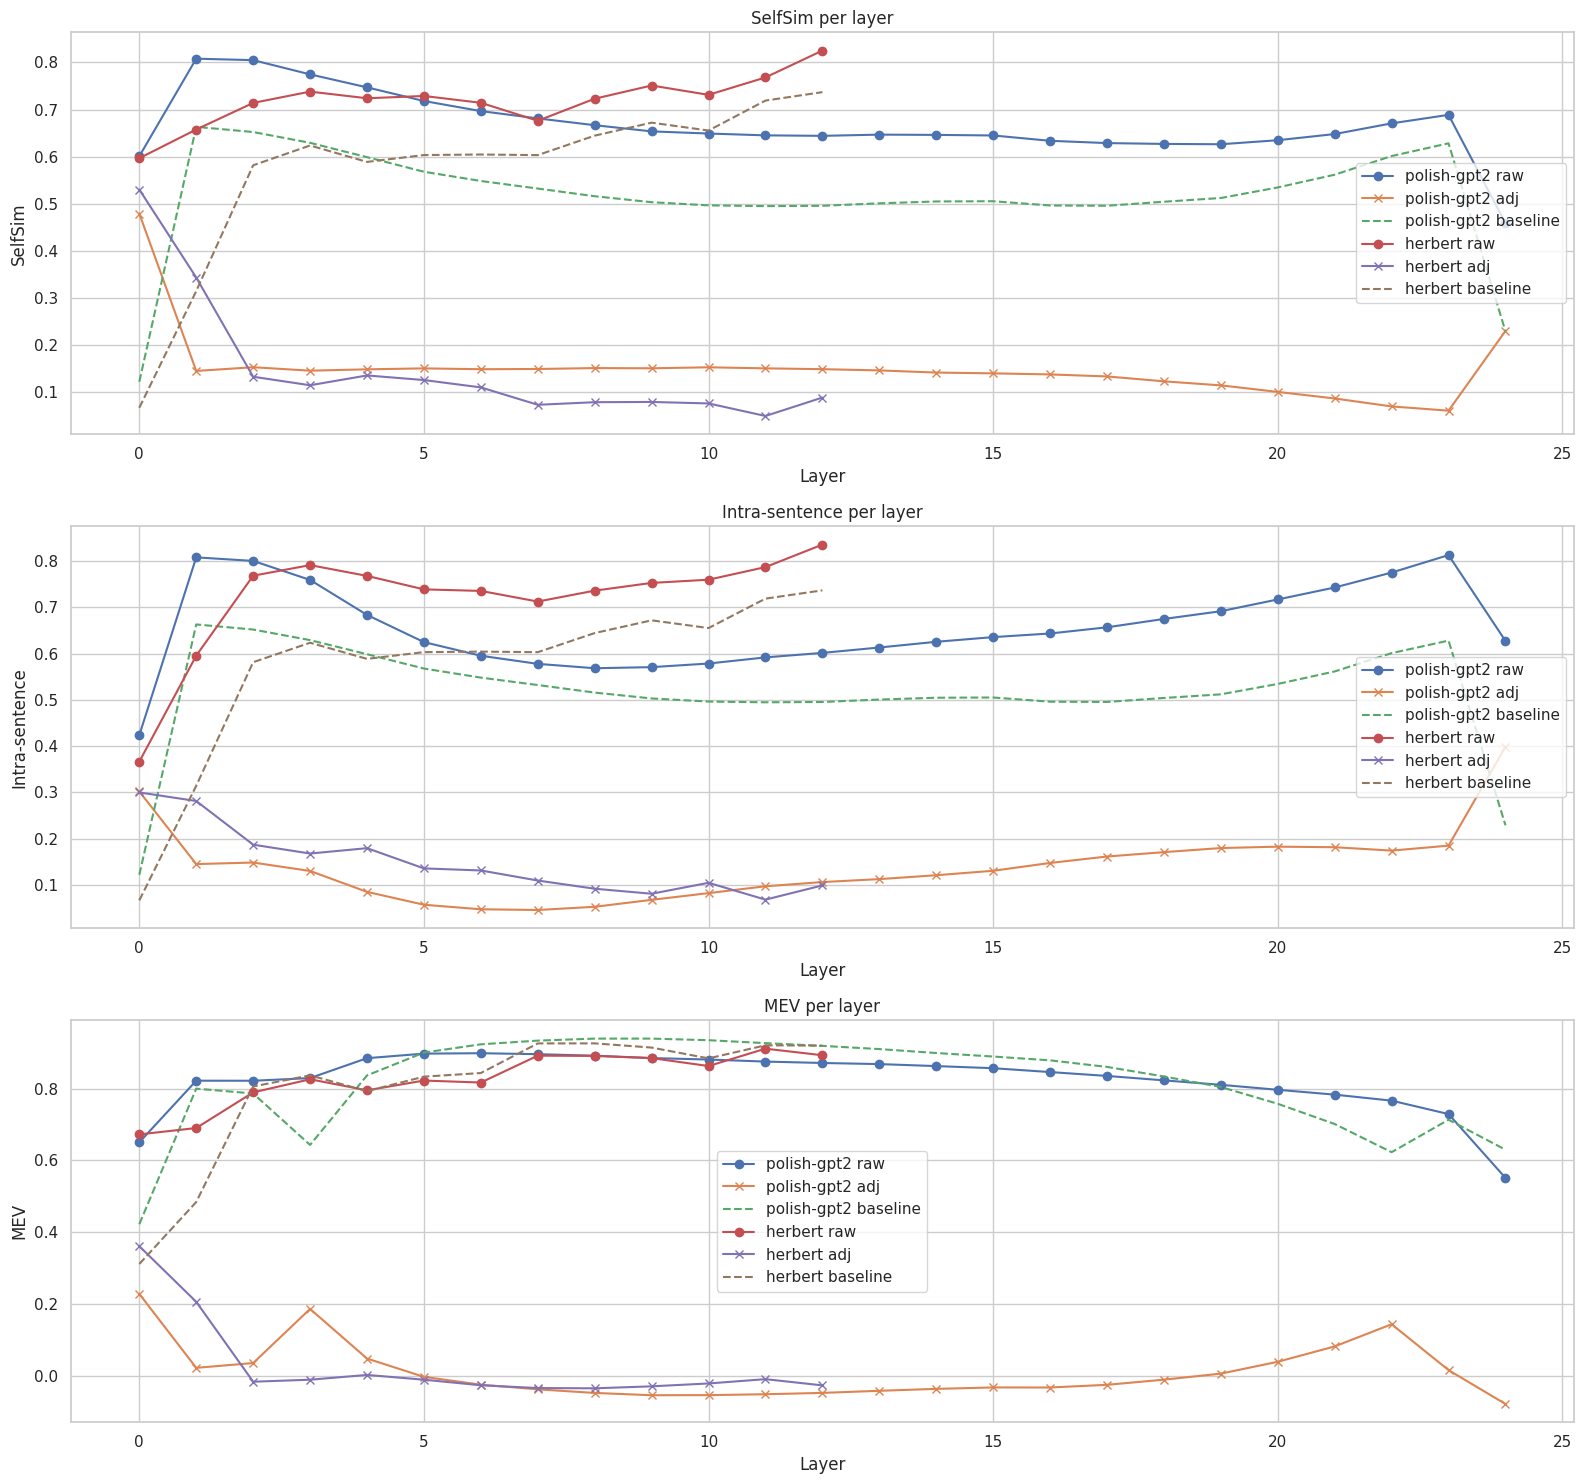

In [ ]:
def plot_all_metrics(results_all):
    """
    Plot all metrics (raw, adjusted, baseline) for all models interactively.
    Includes anisotropy baseline.
    """
    metrics = ["SelfSim", "Intra-sentence", "MEV"]
    metric_keys = {
        "SelfSim": ("raw_self", "adj_self", "anisotropy_baseline"),
        "Intra-sentence": ("raw_intra", "adj_intra", "anisotropy_baseline"),
        "MEV": ("raw_mev", "adj_mev", "mev_baseline")
    }

    n_metrics = len(metrics)
    plt.figure(figsize=(16, 5 * n_metrics))

    for i, metric in enumerate(metrics, 1):
        plt.subplot(n_metrics, 1, i)
        for model_name, res in results_all.items():
            layers = sorted(res.keys())
            raw_key, adj_key, baseline_key = metric_keys[metric]
            raw_vals = [res[L][raw_key] for L in layers]
            adj_vals = [res[L][adj_key] for L in layers]
            baseline_vals = [res[L][baseline_key] for L in layers]

            plt.plot(layers, raw_vals, marker='o', label=f"{model_name} raw")
            plt.plot(layers, adj_vals, marker='x', label=f"{model_name} adj")
            plt.plot(layers, baseline_vals, linestyle='--', label=f"{model_name} baseline")

        plt.title(f"{metric} per layer")
        plt.xlabel("Layer")
        plt.ylabel(metric)
        plt.grid(True)
        plt.legend()

    plt.tight_layout()
    plt.show()


plot_all_metrics(results_all)

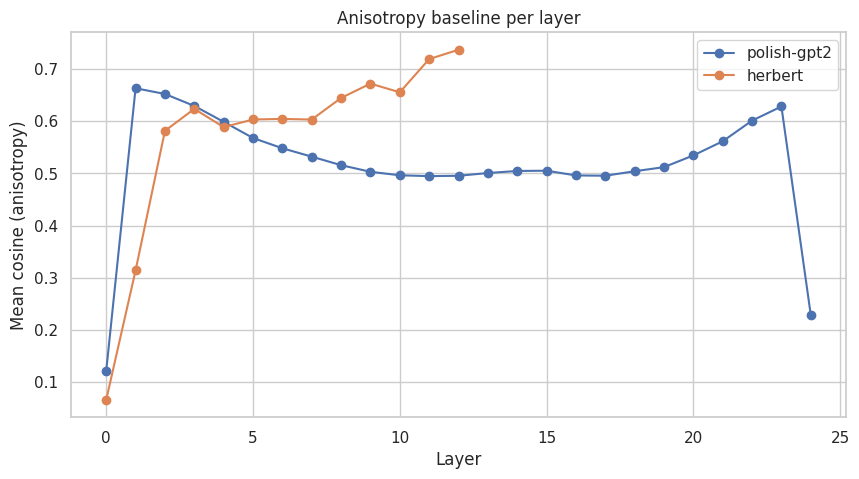

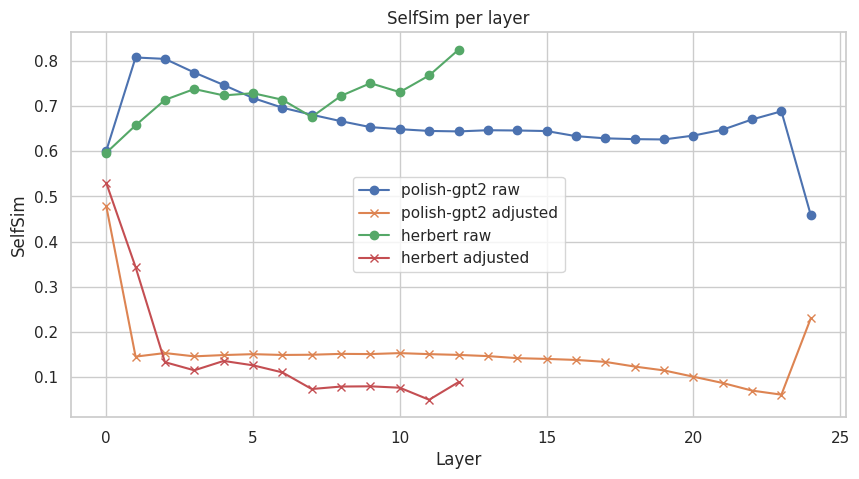

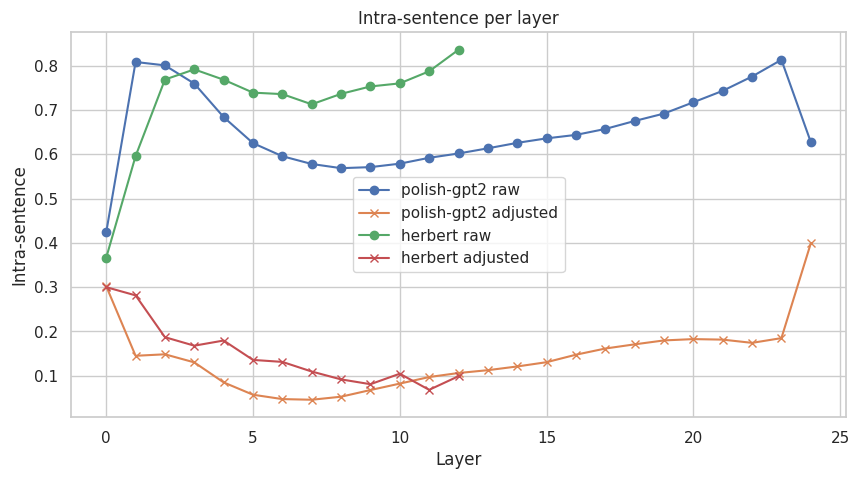

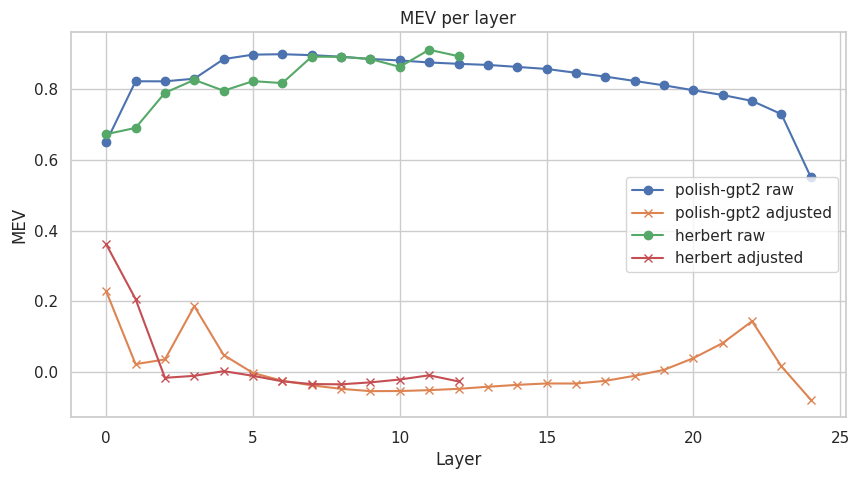

In [ ]:
def plot_metrics_separately_safe(results_all):
    """
    Clean interactive plots with safety against missing layers:
    - Separate anisotropy baseline plot
    - Separate plots for each metric with raw vs adjusted per model
    """
    models = list(results_all.keys())

    # ------------------
    # Anisotropy baseline plot
    # ------------------
    plt.figure(figsize=(10,5))
    for model in models:
        layers = sorted(int(L) for L in results_all[model].keys())
        baseline_vals = [results_all[model][L]["anisotropy_baseline"] for L in layers]
        plt.plot(layers, baseline_vals, marker='o', label=model)
    plt.title("Anisotropy baseline per layer")
    plt.xlabel("Layer")
    plt.ylabel("Mean cosine (anisotropy)")
    plt.grid(True)
    plt.legend()
    plt.show()

    # ------------------
    # Metrics: SelfSim, Intra-sentence, MEV
    # ------------------
    metric_info = {
        "SelfSim": ("raw_self", "adj_self"),
        "Intra-sentence": ("raw_intra", "adj_intra"),
        "MEV": ("raw_mev", "adj_mev")
    }

    for metric_name, (raw_key, adj_key) in metric_info.items():
        plt.figure(figsize=(10,5))
        for model in models:
            layers = sorted(int(L) for L in results_all[model].keys())
            raw_vals = [results_all[model][L][raw_key] for L in layers]
            adj_vals = [results_all[model][L][adj_key] for L in layers]
            plt.plot(layers, raw_vals, marker='o', label=f"{model} raw")
            plt.plot(layers, adj_vals, marker='x', label=f"{model} adjusted")
        plt.title(f"{metric_name} per layer")
        plt.xlabel("Layer")
        plt.ylabel(metric_name)
        plt.grid(True)
        plt.legend()
        plt.show()

plot_metrics_separately_safe(results_all)

In [2]:
from copy import deepcopy

ALNUM_CHARSET = set('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')

def convert_to_tokens(indices, tokenizer, extended=False, extra_values_pos=None, strip=True):
    if extended:
        res = [tokenizer.convert_ids_to_tokens([idx])[0] if idx < len(tokenizer) else
               (f"[pos{idx-len(tokenizer)}]" if idx < extra_values_pos else f"[val{idx-extra_values_pos}]")
               for idx in indices]
    else:
        res = tokenizer.convert_ids_to_tokens(indices)
    if strip:
        res = list(map(lambda x: x[1:] if x[0] == 'Ġ' else "#" + x, res))
    return res


def top_tokens(v, k=100, tokenizer=None, only_alnum=False, only_ascii=True, with_values=False,
               exclude_brackets=False, extended=True, extra_values=None, only_from_list=None):
    if tokenizer is None:
        tokenizer = my_tokenizer
    v = deepcopy(v)
    ignored_indices = []
    if only_ascii:
        ignored_indices.extend([key for val, key in tokenizer.vocab.items() if not val.strip('Ġ▁').isascii()])
    if only_alnum:
        ignored_indices.extend([key for val, key in tokenizer.vocab.items() if not (set(val.strip('Ġ▁[] ')) <= ALNUM_CHARSET)])
    if only_from_list:
        ignored_indices.extend([key for val, key in tokenizer.vocab.items() if val.strip('Ġ▁ ').lower() not in only_from_list])
    if exclude_brackets:
        ignored_indices = set(ignored_indices).intersection(
            {key for val, key in tokenizer.vocab.items() if not (val.isascii() and val.isalnum())})
        ignored_indices = list(ignored_indices)

    ignored_indices = list(set(ignored_indices))
    v[ignored_indices] = -np.inf
    extra_values_pos = len(v)
    if extra_values is not None:
        v = torch.cat([v, extra_values])
    values, indices = torch.topk(v, k=k)
    res = convert_to_tokens(indices, tokenizer, extended=extended, extra_values_pos=extra_values_pos)
    if with_values:
        res = list(zip(res, values.cpu().numpy()))
    return res

In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

MODEL = "sdadas/polish-gpt2-medium"
tokenizer = my_tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForCausalLM.from_pretrained(MODEL, output_hidden_states=True)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(51200, 1024)
    (wpe): Embedding(2048, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): FastGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=51200, bias=False)
)

In [4]:
emb = model.get_output_embeddings().weight.data.T.detach()
num_layers = model.config.n_layer
num_heads = model.config.n_head
hidden_dim = model.config.n_embd
head_size = hidden_dim // num_heads

K = torch.cat([model.get_parameter(f"transformer.h.{j}.mlp.c_fc.weight").T
                           for j in range(num_layers)]).detach()
V = torch.cat([model.get_parameter(f"transformer.h.{j}.mlp.c_proj.weight")
                           for j in range(num_layers)]).detach()

W_Q, W_K, W_V = torch.cat([model.get_parameter(f"transformer.h.{j}.attn.c_attn.weight")
                           for j in range(num_layers)]).detach().chunk(3, dim=-1)
W_O = torch.cat([model.get_parameter(f"transformer.h.{j}.attn.c_proj.weight")
                           for j in range(num_layers)]).detach()

In [5]:
K_heads = K.reshape(num_layers, -1, hidden_dim)
V_heads = V.reshape(num_layers, -1, hidden_dim)
d_int = K_heads.shape[1]

W_Q_heads = W_Q.reshape(num_layers, hidden_dim, num_heads, head_size).permute(0, 2, 1, 3)
W_K_heads = W_K.reshape(num_layers, hidden_dim, num_heads, head_size).permute(0, 2, 1, 3)
W_V_heads = W_V.reshape(num_layers, hidden_dim, num_heads, head_size).permute(0, 2, 1, 3)
W_O_heads = W_O.reshape(num_layers, num_heads, head_size, hidden_dim)
emb_inv = emb.T

In [6]:
tokens_list = set()

## FF layers


In [12]:
# i1, i2 = 23, 907
i1, i2 = np.random.randint(num_layers), np.random.randint(d_int)

print(i1, i2)
print(tabulate([*zip(
    top_tokens((K_heads[i1, i2]) @ emb, k=30, only_from_list=tokens_list, only_alnum=False),
    top_tokens((V_heads[i1, i2]) @ emb, k=30, only_from_list=tokens_list, only_alnum=False),
    # top_tokens((-K_heads[i1, i2]) @ emb, k=200, only_from_list=tokens_list),
    # top_tokens((-V_heads[i1, i2]) @ emb, k=200, only_from_list=tokens_list),
)], headers=['K', 'V', '-K', '-V']))

4 3327
K          V
---------  ------------
#letem     spina
#dniem     Gem
#cielom    specjalny
#jazdem    kalku
#odpowie   pewien
bilansu    skoru
tygod      fundusz
#tygodni   krzywo
#kapita    kwar
#rans      departam
sztabu     pul
symu       #cos
tygodnia   bil
#jazd      czuje
#sztor     klo
#letu      fas
inteli     mikrosko
decydu     hur
#karzem    skromny
depe       specjalnych
#denta     pierdo
#rucho     skro
niedzie    gra
samolotem  inny
komfor     pomocniczych
rywala     paru
#Poje      pora
#mistrzem  ochronnych
rezygna    co
nacjona    skar


In [7]:
def approx_topk(mat, min_k=500, max_k=250_000, th0=10, max_iters=10, verbose=False):
    _get_actual_k = lambda th, th_max: torch.nonzero((mat > th) & (mat < th_max)).shape[0]
    th_max = np.inf
    left, right = 0, th0
    while True:
        actual_k = _get_actual_k(right, th_max)
        if verbose:
            print(f"one more iteration. {actual_k}")
        if actual_k <= max_k:
            break
        left, right = right, right * 2
    if min_k <= actual_k <= max_k:
        th = right
    else:
        for _ in range(max_iters):
            mid = (left + right) / 2
            actual_k = _get_actual_k(mid, th_max)
            if verbose:
                print(f"one more iteration. {actual_k}")
            if min_k <= actual_k <= max_k:
                break
            if actual_k > max_k:
                left = mid
            else:
                right = mid
        th = mid
    return torch.nonzero((mat > th) & (mat < th_max)).tolist()

def get_top_entries(tmp, all_high_pos, only_ascii=False, only_alnum=False, exclude_same=False, exclude_fuzzy=False, tokens_list=None):
    remaining_pos = all_high_pos
    if only_ascii:
        remaining_pos = [*filter(
            lambda x: (tokenizer.decode(x[0]).strip('Ġ▁').isascii() and tokenizer.decode(x[1]).strip('Ġ▁').isascii()),
            remaining_pos)]
    if only_alnum:
        remaining_pos = [*filter(
            lambda x: (tokenizer.decode(x[0]).strip('Ġ▁ ').isalnum() and tokenizer.decode(x[1]).strip('Ġ▁ ').isalnum()),
            remaining_pos)]
    if exclude_same:
        remaining_pos = [*filter(
            lambda x: tokenizer.decode(x[0]).lower().strip() != tokenizer.decode(x[1]).lower().strip(),
            remaining_pos)]
    if exclude_fuzzy:
        remaining_pos = [*filter(
            lambda x: not _fuzzy_eq(tokenizer.decode(x[0]).lower().strip(), tokenizer.decode(x[1]).lower().strip()),
            remaining_pos)]
    if tokens_list:
        remaining_pos = [*filter(
            lambda x: ((tokenizer.decode(x[0]).strip('Ġ▁').lower().strip() in tokens_list) and
                       (tokenizer.decode(x[1]).strip('Ġ▁').lower().strip() in tokens_list)),
            remaining_pos)]

    pos_val = tmp[[*zip(*remaining_pos)]]
    good_cells = [*map(lambda x: (tokenizer.decode(x[0]), tokenizer.decode(x[1])), remaining_pos)]
    good_tokens = list(map(lambda x: Counter(x).most_common(), zip(*good_cells)))
    remaining_pos_best = np.array(remaining_pos)[torch.argsort(pos_val if reverse_list else -pos_val)[:50]]
    good_cells_best = [*map(lambda x: (tokenizer.decode(x[0]), tokenizer.decode(x[1])), remaining_pos_best)]
    # good_cells[:100]
    # list(zip(good_tokens[0], good_tokens[1]))
    return good_cells_best

In [8]:
i1, i2 = np.random.randint(num_layers), np.random.randint(num_heads)
i1, i2 = 10, 3
i1, i2

(10, 3)

In [9]:
W_V_tmp, W_O_tmp = W_V_heads[i1, i2, :], W_O_heads[i1, i2]
tmp = (emb_inv @ (W_V_tmp @ W_O_tmp) @ emb)

In [10]:
exclude_same = False
reverse_list = False
only_ascii = True
only_alnum = False

In [23]:
del W_V_heads

In [16]:
W_V_tmp = None

In [19]:
torch.cuda.empty_cache()

In [24]:
all_high_pos = approx_topk(tmp, th0=1, verbose=True)

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.44 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.27 GiB is free. Process 210841 has 12.47 GiB memory in use. Of the allocated memory 12.32 GiB is allocated by PyTorch, and 24.64 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [21]:

get_top_entries(tmp, all_high_pos, only_ascii=only_ascii, only_alnum=only_alnum,
                exclude_same=exclude_same, tokens_list=None)

NameError: name 'all_high_pos' is not defined